## Question 3

Design a feature selection algorithm to find the best features for classifying the Mnist dataset. Implement a bidirectional search algorithm using the provided objective function as the measure for your search algorithm.

Use the first 10000 samples of training set in the Mnist dataset for feature selection and training set for kNN approach. Use Euclidean distance to calculate Inter-class.

The objective function should be based on this equestion:

### J = Inter Class distance

In [242]:
import gzip
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

image_size = 28
training_samples = 60000

# Importing Train Data
f_train = gzip.open('train-images-idx3-ubyte.gz','r')
f_train.read(16)
buf = f_train.read(image_size * image_size * training_samples)
train_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
# train_data = data.reshape(num_images, image_size, image_size)
train_data = train_data.reshape(training_samples, image_size* image_size)


# Importing Train Labels
f_train_label = gzip.open('train-labels-idx1-ubyte.gz','r')
f_train_label.read(8)
buf = f_train_label.read(training_samples)
train_labels = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)


# Importing Test Data
testing_images = 10000
f_test = gzip.open('t10k-images-idx3-ubyte.gz','r')
f_test.read(16)
buf = f_test.read(image_size * image_size * testing_images)
test_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(testing_images, image_size * image_size)

# Importing Test Labels
f_test_label = gzip.open('t10k-labels-idx1-ubyte.gz','r')
f_test_label.read(8)
buf = f_test_label.read(testing_images)
test_labels = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)


train_data = train_data[0:10000]
train_labels = train_labels[0:10000]

In [228]:
from sklearn.neighbors import KNeighborsClassifier
def apply_knn(train_data, train_labels, k):
    
    train_d =train_data[:8000]
    train_l =train_labels[:8000]
    
    test_d = train_data[8000:]
    test_l =train_labels[8000:]
    
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_d,train_l)
    
    correct = 0
    for i in range(len(test_d)):
        if model.predict([test_d[i]]) == test_l[i]: correct+=1
    
    return correct/len(test_d)

a) Select the set of {10, 50, 150, 392} features based on the implemented feature selection approach and report the accuracy on the test set of MNIST based on kNN with k = 3. Note: you can take advantage of data structure tricks to speed up the efficiency of kNN algorithm.

In [285]:
dimensions = [10,50,150,392]
my_train_data = train_data
new_train_data = None
deleted_j_max_indices = []
deleted_j_min_indices = []
for _ in range(392):
    
    # SFS
    main_mean = np.mean(my_train_data, axis=0)
    mean_i = []
    for i in np.unique(train_labels):
        indices_of_i = np.where(train_labels == i)[0]
        c_i = np.take(my_train_data, indices_of_i, axis=0)
        mean_i.append(np.mean(c_i, axis=0))    

    J_max = 0
    j_max_index = 0
    for i in range(784):
        if i not in deleted_j_max_indices and i not in deleted_j_min_indices:
            distance = 0
            for mean in mean_i:
                distance += euclidean(main_mean[i],mean[i])
            if distance >= J_max:
                J_max = distance
                j_max_index = i
   
    deleted_j_max_indices.append(j_max_index)
    
    if new_train_data is None:
        new_train_data=my_train_data[:,j_max_index]
    else:  
        new_train_data = np.c_[new_train_data, my_train_data[:,j_max_index]]

    
    # SBS
    main_mean = np.mean(my_train_data, axis=0)
    mean_i = []
    for i in np.unique(train_labels):
        indices_of_i = np.where(train_labels == i)[0]
        c_i = np.take(my_train_data, indices_of_i, axis=0)
        mean_i.append(np.mean(c_i, axis=0))  
        
    J_min = J_max
    j_min_index = 0
    for i in range(784):
        if i not in deleted_j_max_indices and i not in deleted_j_min_indices:
            distance = 0
            for mean in mean_i:
                distance += euclidean(main_mean[i],mean[i])
            if distance <= J_min:
                J_min = distance
                j_min_index = i
    
    deleted_j_min_indices.append(j_min_index)

print(new_train_data.shape)

(10000, 392)


In [324]:
accuracies = []
for d in dimensions:
    accuracies.append(apply_knn(new_train_data[:,:d],train_labels, 3))
print(accuracies)

[0.5815, 0.8165, 0.9135, 0.9365]


b) Visualize the selected features for each set in {10, 50, 150, 392} by a zero 2-D plane where the selected features are pixels set to a value of 1. Compare the 4 different planes.

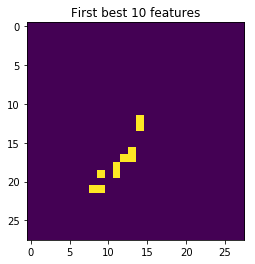

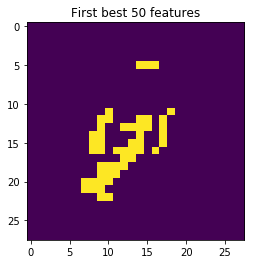

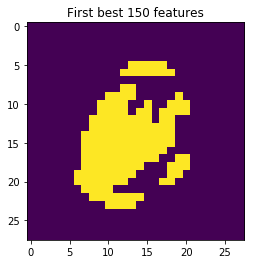

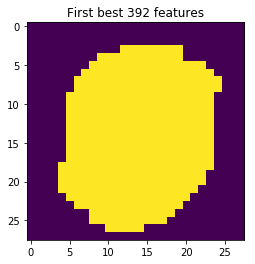

In [292]:
for d in dimensions:
    data = np.zeros(784)
    for val in deleted_j_max_indices[:d]:
        data[val] = 1.0
    data = data.reshape((28, 28))
    plt.imshow(data);
    plt.title("First best %i features"%d)
    plt.show()

c) Apply LDA on the dataset and report the accuracy based on kNN with k = 3. Compare the achieved accuracy by the reported accuracies in part (a). Note: you need to implement LDA method by yourself.

In [323]:
my_train_data = train_data
n_comp=9

overall_mean = np.mean(my_train_data, axis=0)

S_W=np.zeros((784,784))
for i in np.unique(train_labels):
    S=np.zeros((784,784))
    indices_of_i = np.where(train_labels == i)[0]
    c_i = np.take(my_train_data, indices_of_i, axis=0)
    mean = np.mean(c_i, axis=0)
    mean= mean.reshape(784,1)
    for sample in c_i:
        sample= sample.reshape(784,1)
        S=S+np.dot(sample-mean,(sample-mean).T)
    S_W += S      
    
S_B=np.zeros((784,784))
for i in np.unique(train_labels):
    indices_of_i = np.where(train_labels == i)[0]
    c_i = np.take(my_train_data, indices_of_i, axis=0)
    mean = np.mean(c_i, axis=0)
    mean= mean.reshape(784,1)
    overall_mean= overall_mean.reshape(784,1)
    S_B = S_B + len(c_i)*(mean-overall_mean).dot((mean-overall_mean).T)
    
eig_vals, eig_vecs = np.linalg.eig(np.linalg.pinv(S_W).dot(S_b))

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
W = np.hstack([eig_pairs[i][1].reshape(784, 1) for i in range(0, n_comp)])
new_data= my_train_data.dot(W)
apply_knn(new_data.real, train_labels, 3)

0.903